# Выпускной проект

Содержание
1. [Описание проекта](#start)
2. [План работы](#plan)
3. [Обзор данных](#data_view)
4. [Предобработка данных](#processing)
5. [Обучение моделей](#training)
6. [Тестирование модели](#testing)
7. [Отчет по решению](#report)

## Описание проекта <a id='start'></a> 

### Цель проекта 

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Метрика - MAE меньше 8.7**

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).


### Описание данных

Данные состоят из файлов, полученных из разных источников:

* `data_arc.csv` — данные об электродах;
* `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
* `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
* `data_gas.csv` — данные о продувке сплава газом;
* `data_temp.csv` — результаты измерения температуры;
* `data_wire.csv` — данные о проволочных материалах (объём);
* `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


## План работы  <a id='#plan'></a> 

1. Предобработка и исследовательский анализ данных. Проверить наличие пропусков, некорректных значений, дубликатов, провести их обработку, привести данные к нужному типу. Изучить признаки, их основные статистики, построить графики при необходимости. Удалить признаки, которые не будут использоваться в обучении моделей (вызывают утечку целевого признака или являются индификаторами). Подготовить итоговую таблицу "признаки-целевой признак", где уникальными ключами являются номера партий.
2. Обучение моделей. Разделить выборку на обучающую и тестовую. Исследовать модели 2 - 3 модели. Выбрать признаковое пространство, модель и ее гиперпараметры, имеющее лучшее качество на кросс-валидации, сравнение с константной моделью.
3. Оценка эффективности моделей на тестовой выборке. При недостижении целевого значения метрики качества вернуться к этапу обучения модели, сформировать дополнительные признаки, продолжить выбор моделей и настройку гиперпараметров.

## Обзор данных <a id='#data_view'></a> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
import warnings

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')

In [2]:
file_list = ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']
file_dict =  dict.fromkeys(file_list)

for i in file_dict:
    pth1 = i + '.csv'
    pth2 = '/datasets/final_steel/' + i + '.csv'
    if os.path.exists(pth1):
        file_dict[i] = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        file_dict[i] = pd.read_csv(pth2)
    else:
        raise FileNotFoundError('Sorry, the file does not exist')

In [3]:
pd.set_option('display.max_columns', None)

df_arc = file_dict['data_arc']
df_bulk = file_dict['data_bulk']
df_bulk_time = file_dict['data_bulk_time']
df_gas = file_dict['data_gas']
df_temp = file_dict['data_temp']
df_wire = file_dict['data_wire']
df_wire_time = file_dict['data_wire_time']


def check_data(data):
    display(data.head())
    display(data.info())
    display(data.describe())

**Данные об электродах**

In [4]:
check_data(df_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 14876 entries, 0 to 14875

Data columns (total 5 columns):

 #   Column                Non-Null Count  Dtype  

---  ------                --------------  -----  

 0   key                   14876 non-null  int64  

 1   Начало нагрева дугой  14876 non-null  object 

 2   Конец нагрева дугой   14876 non-null  object 

 3   Активная мощность     14876 non-null  float64

 4   Реактивная мощность   14876 non-null  float64

dtypes: float64(2), int64(1), object(2)

memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Первичный анализ данных об электродах показал:
1. В таблице представлена информация: 
* Начало нагрева дугой,
* Конец нагрева дугой,	
* Активная мощность,
* Реактивная мощность.
2. Все столбцы содержат 14 876 записей, пропусков нет.
3. Есть отрицательные значения в столбце с реактивной мощностью.
4. Название столбцов не соответствует PEP8.
5. Поля с датой и временем сохранены в формате object.
6. На одну партию приходится несколько измерений.

Переименуем названия столбцов, преобразуем поля с датой и временем в формат datetime.

In [5]:
df_arc.columns=['key', 'start_time_arc', 'finish_time_arc', 'active_power', 'reactive_power']
df_arc['start_time_arc'] = pd.to_datetime(df_arc['start_time_arc'])
df_arc['finish_time_arc'] = pd.to_datetime(df_arc['finish_time_arc'])
df_arc.head()

,key,start_time_arc,finish_time_arc,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [6]:
#Количество партий стали в данных по электродам
df_arc['key'].nunique()

3214

In [7]:
#Среднее количество обработок для одной партии
df_arc['key'].count() / df_arc['key'].nunique()

4.628500311138768

Таким образом, в данных об электродах содержится информация о 3214 партиях, каждая партия подвергается обработке в среднем 4,6 раза.

In [8]:
#Распределение партий по количеству обработок
df_arc.groupby('key')['key'].count().value_counts()

4     892
5     759
3     520
6     490
7     205
2     174
8      84
1      39
9      28
10      9
11      5
12      3
13      2
15      2
14      1
16      1
Name: key, dtype: int64

Каждая партия подвергается обработке от одного до 16 раз, в основном обрабатываются по 4-5 раз, доля таких партий превышает половину всего количества партий в имеющихся данных, менее 2 и более 7 раз подвергаются обработке сравнительно небольшая доля партий стали.

Детальнее проанализируем показатели активной и реактивной мощности. Построим гистрограммы и "ящики с усами".

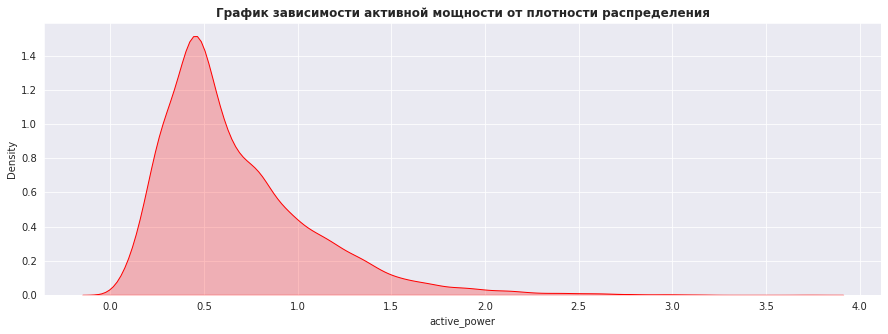

In [9]:
sns.set_style("darkgrid")

plt.figure(figsize=(15, 5))
sns.kdeplot(df_arc['active_power'],color='r', legend=True,shade=True)
plt.title('График зависимости активной мощности от плотности распределения', fontweight='bold')
plt.show();

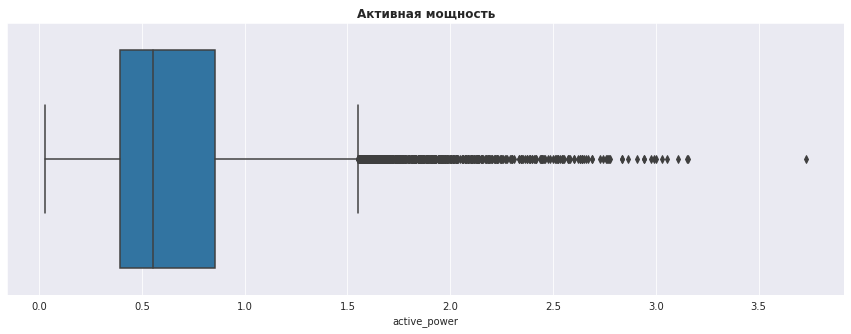

In [10]:
plt.figure(figsize=(15, 5))
sns.boxplot(df_arc['active_power'])
plt.title('Активная мощность', fontweight='bold')
plt.show();

Данные распределены нормально со сдвигом влево.

Для построения графиков по реактивной мощности уберем аномальные отрицательные значения.

In [11]:
df_arc =df_arc[df_arc['reactive_power'] >= 0]

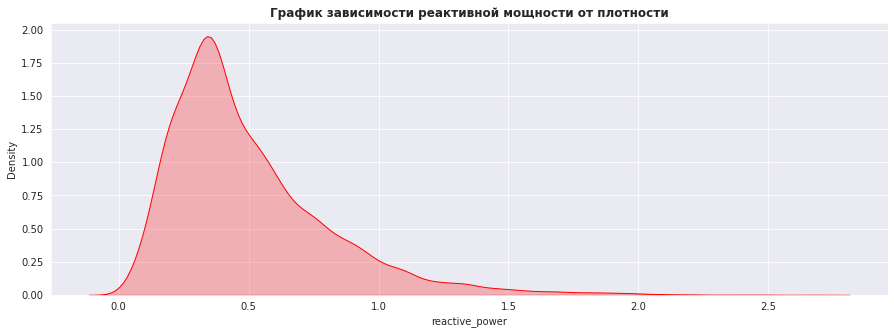

In [12]:
plt.figure(figsize=(15, 5))
sns.kdeplot(df_arc['reactive_power'],color='r', legend=True,shade=True)
plt.title('График зависимости реактивной мощности от плотности', fontweight='bold')
plt.show();

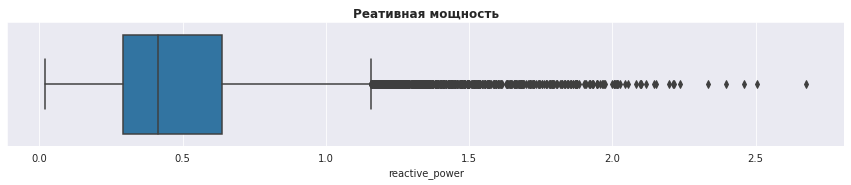

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(2,1,2)
sns.boxplot(df_arc['reactive_power'])
plt.title('Реативная мощность', fontweight='bold')
plt.show();

Данные распределены нормально со сдвигом влево.

Проверим корреляцию между активной и реактивной мощностью.

'Корреляция активной и реактивной мощности'

0.9631819131519804

<Figure size 1080x360 with 0 Axes>

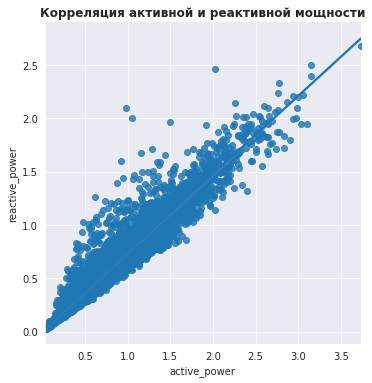

In [14]:
display('Корреляция активной и реактивной мощности', df_arc['active_power'].corr(df_arc['reactive_power']))
plt.figure(figsize=(15,5))
sns.lmplot(x='active_power', y='reactive_power', data=df_arc)
plt.title('Корреляция активной и реактивной мощности', fontweight='bold')
plt.show();

Между активной и реактивной мощностью высокая положительная корреляция.

Время окончания процесса должно быть больше времени начала, проверим это условие.

In [15]:
(df_arc['finish_time_arc'] - df_arc['start_time_arc']).describe()

count                        14875
mean     0 days 00:02:51.675159663
std      0 days 00:01:38.188758501
min                0 days 00:00:11
25%                0 days 00:01:47
50%                0 days 00:02:27
75%                0 days 00:03:34
max                0 days 00:15:07
dtype: object

В среднем процесс длится около 3 минут, минимальная продолжительность обработки составляет 11 секунд, максимальная - чуть больше 15 минут.

Проверим монотонность изменения времени начала процесса.

In [16]:
df_arc['start_time_arc'].is_monotonic

False

Рост временной составляющей не является монотонной, найдем разность между началом текущей записи и началом предыдущей записи.

In [17]:
(df_arc['start_time_arc'] - df_arc['start_time_arc'].shift(1)).describe()

count                        14874
mean     0 days 00:11:41.301129487
std      0 days 01:00:54.065266978
min              -1 days +18:26:57
25%                0 days 00:05:13
50%                0 days 00:07:33
75%                0 days 00:12:27
max                4 days 22:12:29
Name: start_time_arc, dtype: object

In [18]:
df_arc['lag'] = df_arc['start_time_arc'] - df_arc['start_time_arc'].shift(1)
df_arc.query('lag < "00:00:00"').head()

,key,start_time_arc,finish_time_arc,active_power,reactive_power,lag
98,22,2019-05-04 03:56:43,2019-05-04 03:58:46,0.414755,0.336268,-1 days +23:43:22
115,25,2019-05-04 06:22:49,2019-05-04 06:24:56,0.442119,0.354661,-1 days +23:27:38
202,45,2019-05-04 23:02:37,2019-05-04 23:05:52,0.667737,0.554781,-1 days +21:52:34
212,46,2019-05-04 23:46:31,2019-05-04 23:48:13,0.416553,0.312153,-1 days +23:25:11
225,47,2019-05-05 01:13:40,2019-05-05 01:16:12,0.513043,0.426973,-1 days +22:06:21


In [19]:
df_arc.loc[200:215, :]

,key,start_time_arc,finish_time_arc,active_power,reactive_power,lag
200,44,2019-05-05 01:04:04,2019-05-05 01:04:31,0.098206,0.079758,0 days 00:14:43
201,44,2019-05-05 01:10:03,2019-05-05 01:11:13,0.267416,0.211502,0 days 00:05:59
202,45,2019-05-04 23:02:37,2019-05-04 23:05:52,0.667737,0.554781,-1 days +21:52:34
203,45,2019-05-04 23:08:55,2019-05-04 23:15:53,1.765750,1.296387,0 days 00:06:18
204,45,2019-05-04 23:18:43,2019-05-04 23:21:48,0.824910,0.561500,0 days 00:09:48
205,45,2019-05-04 23:22:53,2019-05-04 23:26:00,0.837125,0.566057,0 days 00:04:10
206,45,2019-05-04 23:27:47,2019-05-04 23:30:13,0.650173,0.455494,0 days 00:04:54
207,45,2019-05-04 23:32:14,2019-05-04 23:37:01,1.257520,0.970228,0 days 00:04:27
208,45,2019-05-04 23:38:17,2019-05-04 23:40:21,0.556318,0.368146,0 days 00:06:03
209,45,2019-05-05 00:09:50,2019-05-05 00:14:57,1.336049,0.941818,0 days 00:31:33


Таким образом, одновременно могут протекать несколько процессов обработки, поэтому время процессов может перекрываться.

In [20]:
df_arc.drop('lag', axis=1, inplace=True)

**Данные о подаче сыпучих материалов (объём)**

In [21]:
check_data(df_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3129 entries, 0 to 3128

Data columns (total 16 columns):

 #   Column   Non-Null Count  Dtype  

---  ------   --------------  -----  

 0   key      3129 non-null   int64  

 1   Bulk 1   252 non-null    float64

 2   Bulk 2   22 non-null     float64

 3   Bulk 3   1298 non-null   float64

 4   Bulk 4   1014 non-null   float64

 5   Bulk 5   77 non-null     float64

 6   Bulk 6   576 non-null    float64

 7   Bulk 7   25 non-null     float64

 8   Bulk 8   1 non-null      float64

 9   Bulk 9   19 non-null     float64

 10  Bulk 10  176 non-null    float64

 11  Bulk 11  177 non-null    float64

 12  Bulk 12  2450 non-null   float64

 13  Bulk 13  18 non-null     float64

 14  Bulk 14  2806 non-null   float64

 15  Bulk 15  2248 non-null   float64

dtypes: float64(15), int64(1)

memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Первичный анализ данных о объемах подачи сыпучих материалов показал:
1. Сыпучих материалов для легирования - 15 единиц.
2. Название столбцов не соответствует PEP8.
3. Есть пропуски в столбцах, связанные с технологическим процессом.
4. Материал под номером 8 был добавлен всего в одну партию. Из оставшихся материалов наименьшее количество использований характерно для материалов 2, 9 и 13, они добавлялись в 22, 19 и 17 партий стали соответственно.
5. Явно ошибочных значений в представленной таблице нет - минимальный объем добавок во всех случаях положителен, максимальные объемы для большинства добавок составляют от 185 до 636, для материала 12 - максимальный объем составляет 1849, что выделяет его среди других значений.

Приведем названия столбцов в соответствие с PEP8, проверим столбец `key` на уникальность значений и установим в качестве индекса датафрейма.

In [22]:
df_bulk.columns = [x.replace(' ','_').lower() for x in  df_bulk.columns]
df_bulk['key'].duplicated().sum()

0

In [23]:
df_bulk.set_index('key', inplace=True)
df_bulk.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Детальнее проанализируем объемы сыпучных материалов. Построим "ящики с усами".

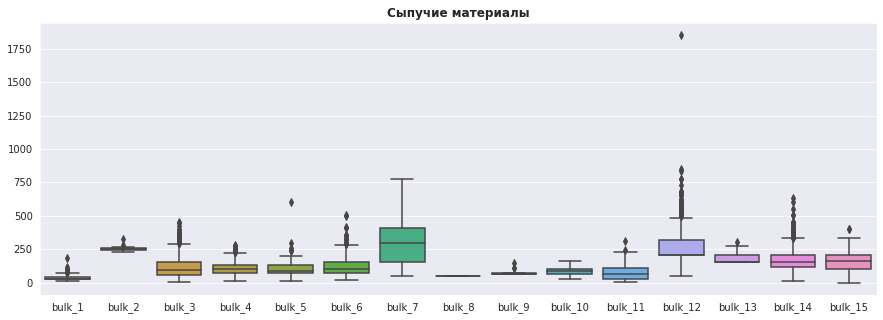

In [24]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_bulk)
plt.title('Сыпучие материалы', fontweight='bold');

Единичное значение объема 1849 для материала под номером 12 действительно похож на выброс, однако уверенности нет, на данном этапе оставим значение без изменения.

**Данные о подаче сыпучих материалов (время)**

In [25]:
check_data(df_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3129 entries, 0 to 3128

Data columns (total 16 columns):

 #   Column   Non-Null Count  Dtype 

---  ------   --------------  ----- 

 0   key      3129 non-null   int64 

 1   Bulk 1   252 non-null    object

 2   Bulk 2   22 non-null     object

 3   Bulk 3   1298 non-null   object

 4   Bulk 4   1014 non-null   object

 5   Bulk 5   77 non-null     object

 6   Bulk 6   576 non-null    object

 7   Bulk 7   25 non-null     object

 8   Bulk 8   1 non-null      object

 9   Bulk 9   19 non-null     object

 10  Bulk 10  176 non-null    object

 11  Bulk 11  177 non-null    object

 12  Bulk 12  2450 non-null   object

 13  Bulk 13  18 non-null     object

 14  Bulk 14  2806 non-null   object

 15  Bulk 15  2248 non-null   object

dtypes: int64(1), object(15)

memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Первичный анализ данных о времени подачи сыпучих материалов показал:
1. Название столбцов не соответствует PEP8.
2. Поля с датой и временем сохранены в формате object.
3. Есть аналогичные датафрейму с объемами пропуски в столбцах, связанные с технологическим процессом.

Приведем названия столбцов в соответствие с PEP8, проверим столбец `key` на уникальность значений и установим в качестве индекса датафрейма.

In [26]:
df_bulk_time.columns = [x.replace(' ','_').lower() for x in  df_bulk_time.columns]
df_bulk_time['key'].duplicated().sum()

0

In [27]:
df_bulk_time.set_index('key', inplace=True)
df_bulk_time.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Преобразуем поля с датой и временем в формат datetime.

In [28]:
for i in range(1,16):
    df_bulk_time['bulk_' + str(i)] = pd.to_datetime(df_bulk_time['bulk_' + str(i)])
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 3129 entries, 1 to 3241

Data columns (total 15 columns):

 #   Column   Non-Null Count  Dtype         

---  ------   --------------  -----         

 0   bulk_1   252 non-null    datetime64[ns]

 1   bulk_2   22 non-null     datetime64[ns]

 2   bulk_3   1298 non-null   datetime64[ns]

 3   bulk_4   1014 non-null   datetime64[ns]

 4   bulk_5   77 non-null     datetime64[ns]

 5   bulk_6   576 non-null    datetime64[ns]

 6   bulk_7   25 non-null     datetime64[ns]

 7   bulk_8   1 non-null      datetime64[ns]

 8   bulk_9   19 non-null     datetime64[ns]

 9   bulk_10  176 non-null    datetime64[ns]

 10  bulk_11  177 non-null    datetime64[ns]

 11  bulk_12  2450 non-null   datetime64[ns]

 12  bulk_13  18 non-null     datetime64[ns]

 13  bulk_14  2806 non-null   datetime64[ns]

 14  bulk_15  2248 non-null   datetime64[ns]

dtypes: datetime64[ns](15)

memory usage: 391.1 KB


**Данные о продувке сплава газом**

In [29]:
check_data(df_gas) 

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3239 entries, 0 to 3238

Data columns (total 2 columns):

 #   Column  Non-Null Count  Dtype  

---  ------  --------------  -----  

 0   key     3239 non-null   int64  

 1   Газ 1   3239 non-null   float64

dtypes: float64(1), int64(1)

memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Первичный анализ данных о продувке сплава газом показал:
1. В таблице представлена информация о объемах продувки партии газом.
2. Название столбцов не соответствует PEP8.
3. Пропуски отсутствуют.

Приведем названия столбцов в соответствие с PEP8, проверим столбец `key` на уникальность значений и установим в качестве индекса датафрейма.

In [30]:
df_gas = df_gas.rename(columns={'Газ 1':'gas'})
df_gas['key'].duplicated().sum()

0

In [31]:
df_gas.set_index('key', inplace=True)
df_gas.head()

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


Детальнее проанализируем показатели продувки газов. Построим гистрограммы и "ящики с усами".

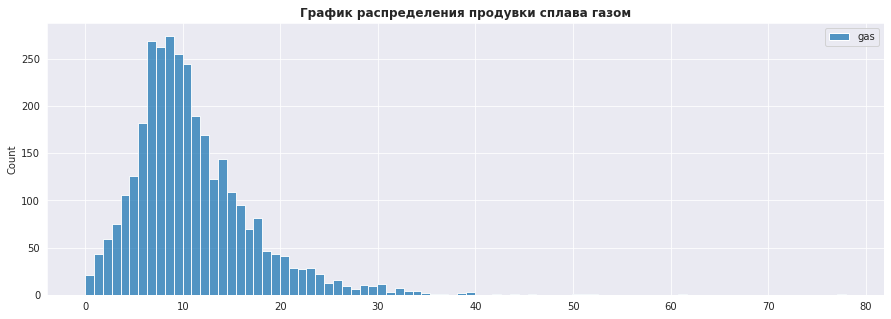

In [32]:
plt.figure(figsize=(15,5))
plt.title('График распределения продувки сплава газом', fontweight='bold')
sns.histplot(data=df_gas)
plt.show();

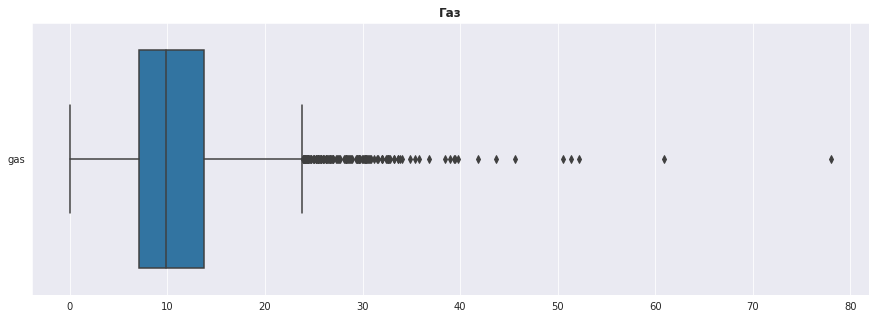

In [33]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_gas, orient='horizontal')
plt.title('Газ', fontweight='bold');
plt.show();

Данные распределены нормально. Объем подаваемого газа составляет в среднем 10 м3, в некоторых случаях достигая 40-80 м3. Т.к. на данном этапе нет информации о допустимых границах этого параметра технологическом процессе, оставим все имеющиеся значения без удаления.

**Результаты измерения температуры**

In [34]:
check_data(df_temp) 

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 15907 entries, 0 to 15906

Data columns (total 3 columns):

 #   Column        Non-Null Count  Dtype  

---  ------        --------------  -----  

 0   key           15907 non-null  int64  

 1   Время замера  15907 non-null  object 

 2   Температура   13006 non-null  float64

dtypes: float64(1), int64(1), object(1)

memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Первичный анализ данных об измерениях температуры показал:
1. В таблице представлена о времени замера и температуры сплава .
2. Название столбцов не соответствует PEP8.
3. Пропуски по температуре есть.
4. Самая минимальная температура ниже диапозона плавления стали (1500 С).
5. Поля с датой и временем сохранены в формате object.
6. Температура для каждой партии замеряется несколько раз.

Приведем названия столбцов в соответствие с PEP8, проверим столбец `key` на уникальность значений и установим в качестве индекса датафрейма.

In [35]:
df_temp.columns=['key', 'time', 'temperature']

In [36]:
df_temp['time'] = pd.to_datetime(df_temp['time'])
df_temp.head()

,key,time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


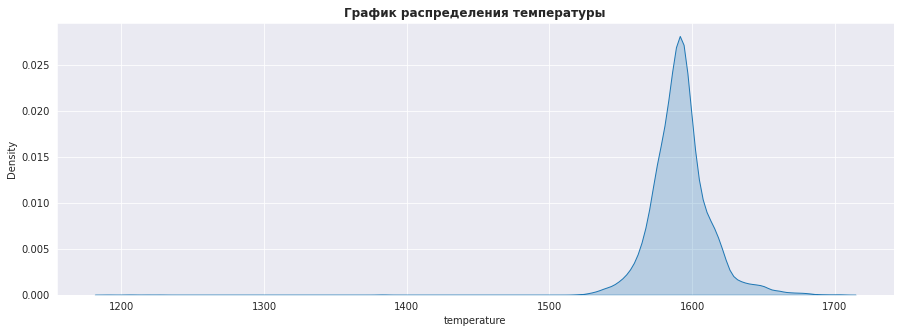

In [37]:
plt.figure(figsize=(15,5))
plt.title('График распределения температуры', fontweight='bold')
sns.kdeplot(df_temp['temperature'], legend=True,shade=True)
plt.show();

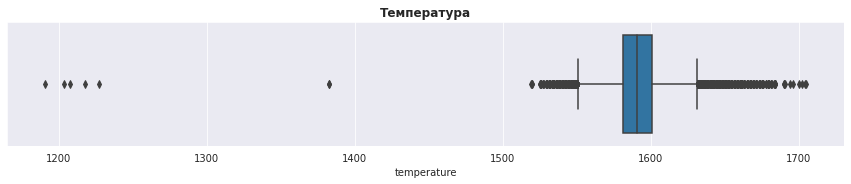

In [38]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,2)
sns.boxplot(df_temp['temperature'])
plt.title('Температура', fontweight='bold');
plt.show();

Распределение температуры сосредоточено в районе 1550 С - 1620 C. Среди значений температуры выделяются несколько значений в районе 1200 C, которые существенно ниже остальных значений и являются нетипичными для данного технологического процесса (ниже температуры плавнения стали - 1500 С), удалим их.

**Данные о проволочных материалах (объём)**

In [39]:
check_data(df_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3081 entries, 0 to 3080

Data columns (total 10 columns):

 #   Column  Non-Null Count  Dtype  

---  ------  --------------  -----  

 0   key     3081 non-null   int64  

 1   Wire 1  3055 non-null   float64

 2   Wire 2  1079 non-null   float64

 3   Wire 3  63 non-null     float64

 4   Wire 4  14 non-null     float64

 5   Wire 5  1 non-null      float64

 6   Wire 6  73 non-null     float64

 7   Wire 7  11 non-null     float64

 8   Wire 8  19 non-null     float64

 9   Wire 9  29 non-null     float64

dtypes: float64(9), int64(1)

memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Первичный анализ данных о объемах подаче проволочных материалов показал:
1. Проволочных материалов для легирования - 9 единиц.
2. Название столбцов не соответствует PEP8.
3. Есть пропуски в столбцах, связанные с технологическим процессом.
4. Материал под номером 5 был добавлен всего в одну партию. Из оставшихся материалов наименьшее количество использований характерно для материалов 4, 7, 8 и 9, они добавлялись в 14, 11, 19 и 29 партий стали соответственно.
5. Явно ошибочных значений в представленной таблице нет - минимальный объем добавок во всех случаях положителен, максимальные объемы для большинства добавок составляют от 33 до 385, миниальные - от 0,03 до 4,62.

Приведем названия столбцов в соответствие с PEP8, проверим столбец `key` на уникальность значений и установим в качестве индекса датафрейма.

In [40]:
df_wire.columns = [x.replace(' ','_').lower() for x in  df_wire.columns]
df_wire['key'].duplicated().sum()

0

In [41]:
df_wire.set_index('key', inplace=True)
df_wire.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Детальнее проанализируем объемы подачи проволочных материалов. Построим "ящики с усами".

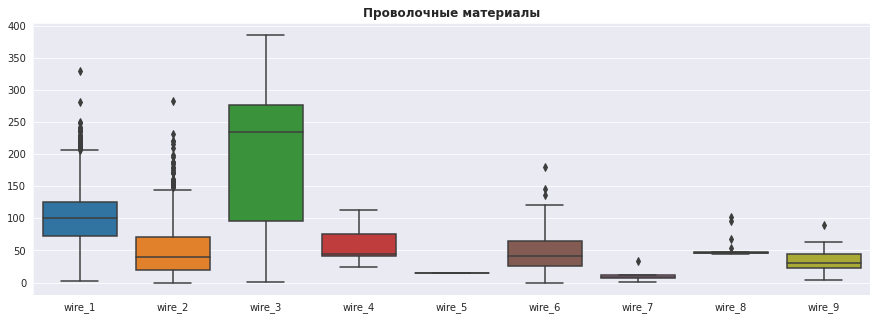

In [42]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_wire)
plt.title('Проволочные материалы', fontweight='bold');

Явных выбросов в объеме проволочных материалов нет.

**Данные о проволочных материалах (время)**

In [43]:
check_data(df_wire_time) 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3081 entries, 0 to 3080

Data columns (total 10 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   key     3081 non-null   int64 

 1   Wire 1  3055 non-null   object

 2   Wire 2  1079 non-null   object

 3   Wire 3  63 non-null     object

 4   Wire 4  14 non-null     object

 5   Wire 5  1 non-null      object

 6   Wire 6  73 non-null     object

 7   Wire 7  11 non-null     object

 8   Wire 8  19 non-null     object

 9   Wire 9  29 non-null     object

dtypes: int64(1), object(9)

memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Первичный анализ данных о времени подачи проволочных материалов показал:
1. Название столбцов не соответствует PEP8.
2. Поля с датой и временем сохранены в формате object.
3. Есть аналогичные датафрейму с объемами пропуски в столбцах, связанные с технологическим процессом.

Приведем названия столбцов в соответствие с PEP8, проверим столбец `key` на уникальность значений и установим в качестве индекса датафрейма.

In [44]:
df_wire_time.columns = [x.replace(' ','_').lower() for x in  df_wire_time.columns]
df_wire_time['key'].duplicated().sum()

0

In [45]:
df_wire_time.set_index('key', inplace=True)
df_wire_time.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Преобразуем поля с датой и временем в формат datetime.

In [46]:
for i in range(1,10):
    df_wire_time['wire_' + str(i)] = pd.to_datetime(df_wire_time['wire_' + str(i)])
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 3081 entries, 1 to 3241

Data columns (total 9 columns):

 #   Column  Non-Null Count  Dtype         

---  ------  --------------  -----         

 0   wire_1  3055 non-null   datetime64[ns]

 1   wire_2  1079 non-null   datetime64[ns]

 2   wire_3  63 non-null     datetime64[ns]

 3   wire_4  14 non-null     datetime64[ns]

 4   wire_5  1 non-null      datetime64[ns]

 5   wire_6  73 non-null     datetime64[ns]

 6   wire_7  11 non-null     datetime64[ns]

 7   wire_8  19 non-null     datetime64[ns]

 8   wire_9  29 non-null     datetime64[ns]

dtypes: datetime64[ns](9)

memory usage: 240.7 KB


Таким образом, были проанализированы данные, описывающие различные технологические процессы при подготовке стали и собранные в семи таблицах:
* data_arc.csv — данные об электродах;
* data_bulk.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time.csv — данные о подаче сыпучих материалов (время);
* data_gas.csv — данные о продувке сплава газом;
* data_temp.csv — результаты измерения температуры;
* data_wire.csv — данные о проволочных материалах (объём);
* data_wire_time.csv — данные о проволочных материалах (время).

Исследование на наличие пропусков, выбросов и ошибочных значений выявило пропуски, обусловленные особенностью технологического производства, в датасетах: df_bulk, df_bulk_time, df_wire, df_wire_time и выбросы в показателях реактивной мощности и температуре.

Явные дубликаты в данных отсутствуют.

Поля с датой и временем были преобразованы формат datetime.

## Предобработка данных <a id='#processing'></a> 

Проведем замену на ноль пропусков, обусловленных  особенностью технологического производства, в датасетах: df_bulk, и df_wire.

Заменим пропуски на нули в df_bulk, просуммируем все значения объема для каждой партии, удалим материал под номером 8 с единичным значением ввиду нематериальности.

In [47]:
df_bulk = df_bulk.fillna(0)
df_bulk['bulk_sum'] = df_bulk.sum(axis=1)
df_bulk.drop('bulk_8', axis=1, inplace=True)
df_bulk

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0
3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0
3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0


Заменим пропуски на нули в df_wire, просуммируем все значения объема для каждой партии, удалим материал под номером 5 с единичным значением ввиду нематериальности.

In [48]:
df_wire = df_wire.fillna(0)
df_wire['wire_sum'] = df_wire.sum(axis=1)
df_wire.drop('wire_5', axis=1, inplace=True)
df_wire

,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,wire_sum
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,98.352796
...,...,...,...,...,...,...,...,...,...
3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,38.088959
3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,56.128799
3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,143.357761


Рассчитаем общую мощность, общую длительность обработки электродами, затраченную энергии на обработку.

In [49]:
df_arc['total_power'] = np.sqrt(df_arc['active_power']**2 + df_arc['reactive_power']**2)
df_arc['duration_arc'] = ((df_arc['finish_time_arc'] - df_arc['start_time_arc'])
                          .astype('timedelta64[s]')
                         )
df_arc['energy'] = df_arc['total_power'] * df_arc['duration_arc']
df_arc.head()

,key,start_time_arc,finish_time_arc,active_power,reactive_power,total_power,duration_arc,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228.0,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185.0,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172.0,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365.0,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148.0,119.471318


Агрегируем полученные данные по ключу, добавим также общее количество этапов обработки.

In [50]:
agg_func_arc = {
    'key'            : 'count', 
    'start_time_arc' : 'first',
    'finish_time_arc': 'last',
    'active_power'   : 'mean',
    'reactive_power' : 'mean',
    'total_power'    : 'mean',
    'duration_arc'   : 'sum',
    'energy'         : 'sum'
}

df_arc_group = df_arc.groupby('key').agg(agg_func_arc).rename(columns={'key':'count_arc'})
df_arc_group

,count_arc,start_time_arc,finish_time_arc,active_power,reactive_power,total_power,duration_arc,energy
key,,,,,,,,
1,5,2019-05-03 11:02:14,2019-05-03 11:28:37,0.975629,0.636648,1.165279,1098.0,1442.377754
2,4,2019-05-03 11:34:14,2019-05-03 11:53:18,0.763150,0.499528,0.912304,811.0,881.233565
3,5,2019-05-03 12:06:54,2019-05-03 12:32:19,0.505176,0.319815,0.597907,655.0,525.066777
4,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.802313,0.515074,0.953741,741.0,796.911309
5,4,2019-05-03 13:11:13,2019-05-03 13:33:55,0.836793,0.563161,1.008939,869.0,1199.137958
...,...,...,...,...,...,...,...,...
3237,5,2019-08-31 22:41:18,2019-08-31 23:03:48,0.786493,0.565692,0.968996,909.0,958.336236
3238,3,2019-08-31 23:26:18,2019-08-31 23:41:28,0.702176,0.560394,0.898847,546.0,555.867370
3239,8,2019-09-01 01:26:53,2019-09-01 02:15:43,0.583344,0.388952,0.701485,1216.0,1013.067719


Рассчитаем столбцы с временем начала добавления сыпучих материалов, окончания и длительности процесса.

In [51]:
df_bulk_time['start_time_bulk'] = df_bulk_time.min(axis=1)
df_bulk_time['finish_time_bulk'] = df_bulk_time.max(axis=1)
df_bulk_time['duration_bulk'] = ((df_bulk_time['finish_time_bulk'] - df_bulk_time['start_time_bulk'])
                                 .astype('timedelta64[s]')
                                )
                                
df_bulk_time.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,start_time_bulk,finish_time_bulk,duration_bulk
key,,,,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:21:30,1058.0
2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:46:38,378.0
3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:31:06,1286.0
4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:48:43,439.0
5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:18:50,354.0


Оставим только рассчитанные столбцы.

In [52]:
df_bulk_time_group = df_bulk_time[['start_time_bulk', 'finish_time_bulk','duration_bulk']]
df_bulk_time_group.describe()

,duration_bulk
count,3129.000000
mean,576.501438
std,769.158876
min,0.000000
25%,211.000000
50%,414.000000
75%,741.000000
max,15669.000000


Рассчитаем столбцы с временем начала добавления проволочных материалов, окончания и длительности процесса.

In [53]:
df_wire_time['start_time_wire'] = df_wire_time.min(axis=1)
df_wire_time['finish_time_wire'] = df_wire_time.max(axis=1)
df_wire_time['duration_wire'] = ((df_wire_time['finish_time_wire'] - df_wire_time['start_time_wire'])
                                 .astype('timedelta64[s]')
                                )
df_wire_time.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,start_time_wire,finish_time_wire,duration_wire
key,,,,,,,,,,,,
1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:11:41,2019-05-03 11:11:41,0.0
2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:46:10,2019-05-03 11:46:10,0.0
3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:13:47,2019-05-03 12:13:47,0.0
4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:48:05,2019-05-03 12:48:05,0.0
5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:18:15,2019-05-03 13:32:06,831.0


Оставим только рассчитанные столбцы.

In [54]:
df_wire_time_group = df_wire_time[['start_time_wire', 'finish_time_wire','duration_wire']]
df_wire_time_group.describe()

,duration_wire
count,3081.000000
mean,159.209348
std,563.710151
min,0.000000
25%,0.000000
50%,0.000000
75%,80.000000
max,18756.000000


Преобразуем таблицу, оставив только температуры, соответствующие первому и последнему замеру, а также дату и время соответствующих замеров.

In [55]:
df_temp_group = (df_temp
                 .groupby('key')['time']
                 .agg(['first', 'last'])
                 .reset_index()
                 .rename(columns= {'first':'start_time_temp','last':'finish_time_temp'})
                )
df_temp_group

,key,start_time_temp,finish_time_temp
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01
...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16


In [56]:
df_temp_group = (df_temp_group
                             .merge(df_temp, left_on=['key', 'start_time_temp'], 
                                    right_on=['key', 'time'])
                             .rename(columns={'temperature':'start_temperature'})
                )
df_temp_group = (df_temp_group
                              .merge(df_temp, left_on=['key', 'finish_time_temp'], 
                                     right_on=['key', 'time'])
                              .rename(columns={'temperature':'finish_temperature'})
                )
df_temp_group

,key,start_time_temp,finish_time_temp,time_x,start_temperature,time_y,finish_temperature
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43,2019-08-31 22:44:04,1569.0,2019-08-31 23:05:43,NaN
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00,2019-08-31 23:30:31,1584.0,2019-08-31 23:43:00,NaN
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15,2019-09-01 01:31:47,1598.0,2019-09-01 02:24:15,NaN
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16,2019-09-01 02:39:01,1617.0,2019-09-01 03:35:16,NaN


In [57]:
df_temp_group.drop(['time_x', 'time_y'], axis=1, inplace=True)
df_temp_group.set_index('key', inplace=True)

Удалим данные, где замер температуры меньше температуры плавления (меньше 1500 С).

In [58]:
df_temp_group = (df_temp_group
                 .drop(df_temp_group[df_temp_group['start_temperature'] < 1500]
                 .index)
                )

df_temp_group.shape

(3211, 4)

Замер конечной температуры в полученной таблице есть не для всех строк. Т.к. данный признак является целевым, придется исключить из рассмотрения эти партии.

In [59]:
df_temp_group['finish_temperature'].isna().agg(['sum', 'mean'])

sum     738.000000
mean      0.229835
Name: finish_temperature, dtype: float64

Отсутствует информация по конечной температуре о 738 партиях, что составляет почти 23% от всех данных.

In [60]:
df_temp_group.dropna(inplace=True)
df_temp_group.shape[0]

2473

Подготовим итоговую таблицу для обучения моделей. В нее войдут партии, по которым представлена информация на каждом из этапов подготовки сплава, т.к. каждая партия проходит все этапы подготовки и отсутствие записи на каком либо-этапе свидетелствует скорее об утере информации, что может негативно отразиться на качестве модели.

In [61]:
df_total = df_temp_group.join([df_arc_group, df_bulk, df_bulk_time_group, df_gas, df_wire, 
                               df_wire_time_group],
                              how='inner')
df_total

,start_time_temp,finish_time_temp,start_temperature,finish_temperature,count_arc,start_time_arc,finish_time_arc,active_power,reactive_power,total_power,duration_arc,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,start_time_bulk,finish_time_bulk,duration_bulk,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,wire_sum,start_time_wire,finish_time_wire,duration_wire
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,5,2019-05-03 11:02:14,2019-05-03 11:28:37,0.975629,0.636648,1.165279,1098.0,1442.377754,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,2019-05-03 11:03:52,2019-05-03 11:21:30,1058.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,2019-05-03 11:11:41,2019-05-03 11:11:41,0.0
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,4,2019-05-03 11:34:14,2019-05-03 11:53:18,0.763150,0.499528,0.912304,811.0,881.233565,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,2019-05-03 11:40:20,2019-05-03 11:46:38,378.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,2019-05-03 11:46:10,2019-05-03 11:46:10,0.0
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,5,2019-05-03 12:06:54,2019-05-03 12:32:19,0.505176,0.319815,0.597907,655.0,525.066777,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,2019-05-03 12:09:40,2019-05-03 12:31:06,1286.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,2019-05-03 12:13:47,2019-05-03 12:13:47,0.0
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.802313,0.515074,0.953741,741.0,796.911309,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,2019-05-03 12:41:24,2019-05-03 12:48:43,439.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,2019-05-03 12:48:05,2019-05-03 12:48:05,0.0
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,4,2019-05-03 13:11:13,2019-05-03 13:33:55,0.836793,0.563161,1.008939,869.0,1199.137958,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,2019-05-03 13:12:56,2019-05-03 13:18:50,354.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,2019-05-03 13:18:15,2019-05-03 13:32:06,831.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,4,2019-08-06 00:31:05,2019-08-06 00:51:13,0.802673,0.590194,0.996717,723.0,778.818234,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,719.0,2019-08-06 00:32:18,2019-08-06 00:49:21,1023.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,89.150879,2019-08-06 00:36:13,2019-08-06 00:36:13,0.0
2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,6,2019-08-06 01:00:06,2019-08-06 01:23:32,0.700511,0.468364,0.842839,940.0,875.261419,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,796.0,2019-08-06 01:06:37,2019-08-06 01:14:16,459.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,114.179527,2019-08-06 01:13:33,2019-08-06 01:13:33,0.0
2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,3,2019-08-06 01:38:01,2019-08-06 01:50:45,0.737460,0.617090,0.961672,569.0,556.930349,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,665.0,2019-08-06 01:38:53,2019-08-06 01:43:02,249.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,103.134723,2019-08-06 01:42:27,2019-08-06 01:42:51,24.0


Проверим, что время замера конечной температуры - самое последнее значение даты-времени для каждой партии.

In [62]:
date_columns = df_total.select_dtypes('datetime').columns
display(date_columns)
df_total['is_finish_time_temp_last'] = ((df_total['finish_time_temp'] >= df_total[date_columns]
                                        .max(axis=1))
                                        .astype(int)
                                       )
df_total[df_total['is_finish_time_temp_last'] == 0][date_columns]

Index(['start_time_temp', 'finish_time_temp', 'start_time_arc',
       'finish_time_arc', 'start_time_bulk', 'finish_time_bulk',
       'start_time_wire', 'finish_time_wire'],
      dtype='object')

,start_time_temp,finish_time_temp,start_time_arc,finish_time_arc,start_time_bulk,finish_time_bulk,start_time_wire,finish_time_wire
key,,,,,,,,
11,2019-05-03 16:54:18,2019-05-03 17:27:23,2019-05-03 16:49:14,2019-05-03 17:29:07,2019-05-03 17:03:52,2019-05-03 17:16:34,2019-05-03 17:15:01,2019-05-03 17:15:01
38,2019-05-04 16:07:11,2019-05-04 16:26:37,2019-05-04 16:03:36,2019-05-04 16:27:24,2019-05-04 16:11:42,2019-05-04 16:20:16,2019-05-04 16:09:11,2019-05-04 16:17:14
43,2019-05-04 20:19:45,2019-05-04 20:48:10,2019-05-04 20:15:41,2019-05-04 20:49:31,2019-05-04 20:23:24,2019-05-04 20:34:07,2019-05-04 20:32:51,2019-05-04 20:33:21
64,2019-05-05 16:34:22,2019-05-05 17:26:46,2019-05-05 16:30:48,2019-05-05 17:28:20,2019-05-05 16:41:19,2019-05-05 16:45:05,2019-05-05 16:43:14,2019-05-05 16:44:30
69,2019-05-05 20:31:59,2019-05-05 21:10:40,2019-05-05 20:27:21,2019-05-05 21:12:19,2019-05-05 20:36:30,2019-05-05 21:00:55,2019-05-05 20:34:57,2019-05-05 20:59:49
...,...,...,...,...,...,...,...,...
2421,2019-08-03 08:46:50,2019-08-03 09:06:23,2019-08-03 08:43:08,2019-08-03 09:04:59,2019-08-03 08:49:32,2019-08-03 09:06:24,2019-08-03 08:51:33,2019-08-03 08:54:27
2425,2019-08-03 10:55:10,2019-08-03 11:12:36,2019-08-03 10:51:06,2019-08-03 11:14:38,2019-08-03 10:58:47,2019-08-03 11:03:08,2019-08-03 11:02:23,2019-08-03 11:02:59
2427,2019-08-03 12:01:04,2019-08-03 12:19:34,2019-08-03 11:55:38,2019-08-03 12:21:48,2019-08-03 12:04:33,2019-08-03 12:09:33,2019-08-03 12:07:40,2019-08-03 12:08:33


У 123 партии время замера конечной температуры не самое последнее значение даты-времени, т.е. после замера нет "конечной" темпертатуры, т.к. есть неточности в синхронности датчиков.

Удалим лишние признаки, связанные со временем, приведем таблицу объекты-признаки к итоговому виду перед началом моделирования.

In [63]:
df_total.drop(date_columns, axis=1, inplace=True)
df_total.drop('is_finish_time_temp_last', axis=1, inplace=True)
df_total

,start_temperature,finish_temperature,count_arc,active_power,reactive_power,total_power,duration_arc,energy,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,duration_bulk,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,wire_sum,duration_wire
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,5,0.975629,0.636648,1.165279,1098.0,1442.377754,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,1058.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,0.0
2,1581.0,1602.0,4,0.763150,0.499528,0.912304,811.0,881.233565,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,378.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,0.0
3,1596.0,1599.0,5,0.505176,0.319815,0.597907,655.0,525.066777,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,1286.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,0.0
4,1601.0,1625.0,4,0.802313,0.515074,0.953741,741.0,796.911309,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,439.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,0.0
5,1576.0,1602.0,4,0.836793,0.563161,1.008939,869.0,1199.137958,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,354.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,831.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,4,0.802673,0.590194,0.996717,723.0,778.818234,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,719.0,1023.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,89.150879,0.0
2496,1554.0,1591.0,6,0.700511,0.468364,0.842839,940.0,875.261419,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,796.0,459.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,114.179527,0.0
2497,1571.0,1589.0,3,0.737460,0.617090,0.961672,569.0,556.930349,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,665.0,249.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,103.134723,24.0


Рассмотрим наиболее коррелирующие признаки.

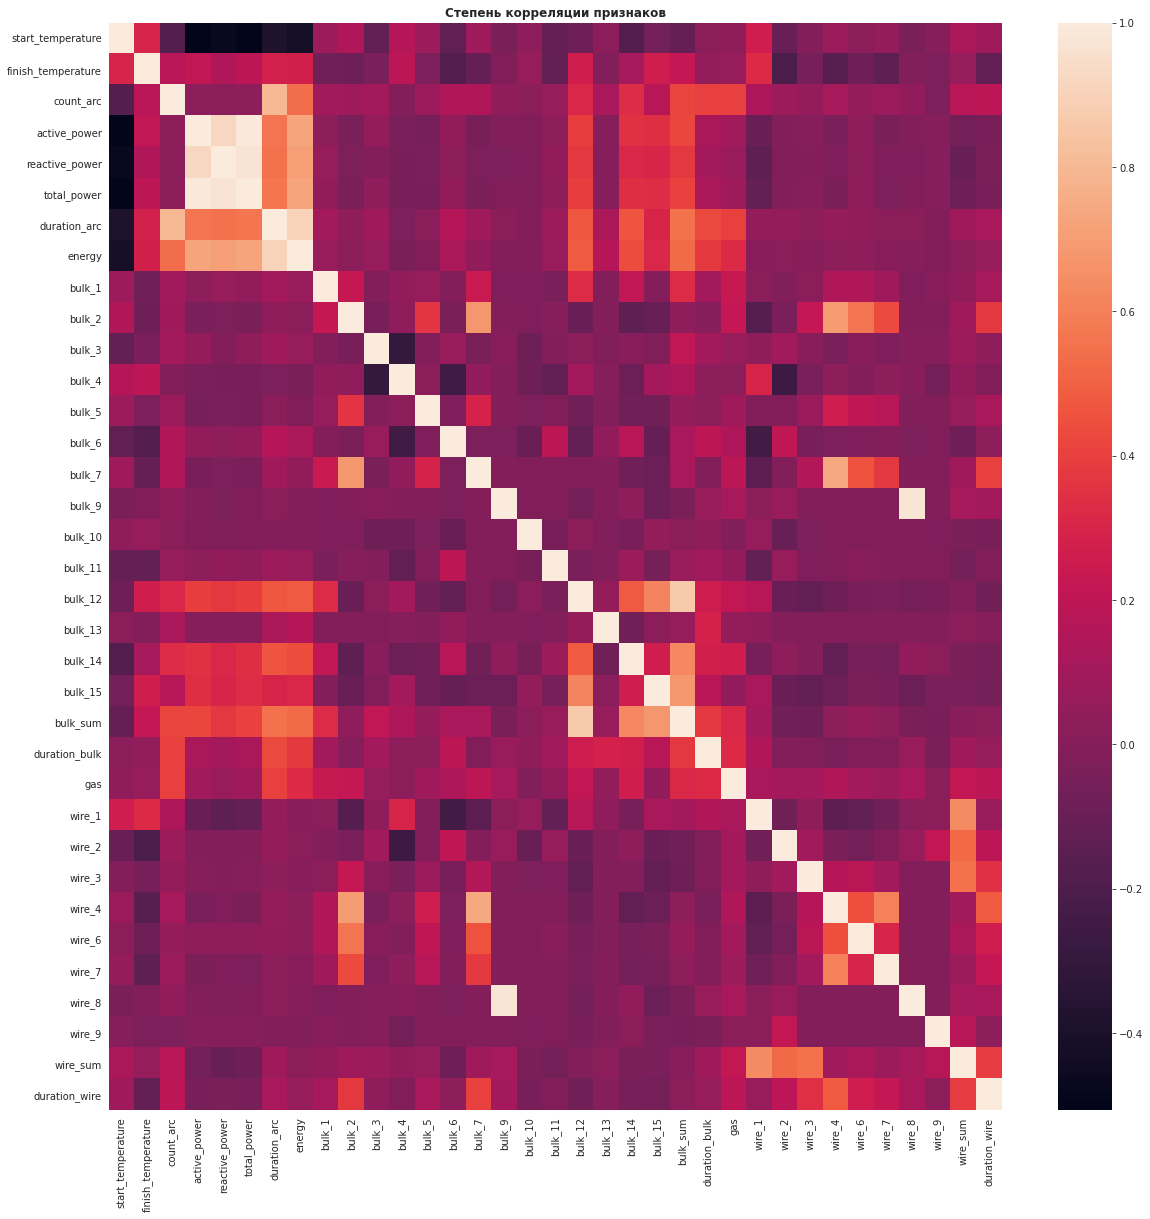

In [64]:
plt.figure(figsize=(20,20))
plt.title('Степень корреляции признаков', fontweight='bold');
sns.heatmap(df_total.corr())
plt.show();

In [65]:
df_total.corr().unstack()[(df_total.corr().unstack() < 1) & (abs(df_total.corr().unstack()) > 0.7)]

count_arc       duration_arc      0.798907
active_power    reactive_power    0.922957
                total_power       0.988394
                energy            0.724161
reactive_power  active_power      0.922957
                total_power       0.970473
                energy            0.700011
total_power     active_power      0.988394
                reactive_power    0.970473
                energy            0.729267
duration_arc    count_arc         0.798907
                energy            0.900210
energy          active_power      0.724161
                reactive_power    0.700011
                total_power       0.729267
                duration_arc      0.900210
bulk_7          wire_4            0.740570
bulk_9          wire_8            0.974968
bulk_12         bulk_sum          0.867932
bulk_sum        bulk_12           0.867932
wire_4          bulk_7            0.740570
wire_8          bulk_9            0.974968
dtype: float64

В основном высокая корреляция наблюдается между характеристиками электродов (количество обработок и длительность, показателями мощности). Некоторые сыпучие и проволочные материалы, предположительно, используются чаще всего вместе, поэтому коррелируют между собой.

Посмотрим также на признаки сильнее всего коррелирующие с целевым признаком.

In [66]:
corr_target = pd.Series()
for col in df_total.columns:
    corr_target[col] = df_total['finish_temperature'].corr(df_total[col])
corr_target = corr_target.sort_values(ascending=False)[1:]

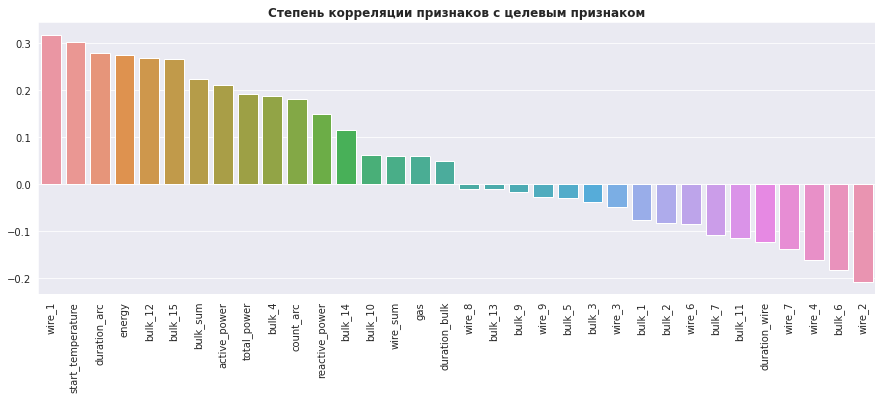

In [67]:
plt.figure(figsize=(15,5))
plt.title('Степень корреляции признаков с целевым признаком', fontweight='bold');
sns.barplot(x=corr_target.index, y=corr_target.values)
plt.xticks(rotation=90)
plt.show();

Признаков сильно коррелирующих с целевым признаком нет, максимальная корреляция наблюдается около 0,3 с проволочным материалом 1, начальной температурой и затраченной энергии на обработки.

Таким образом, были проведены следующие преобразования:
* проведена замена на ноль пропусков, обусловленных  особенностью технологического производства, в датасетах: df_bulk, df_wire. Проводить замены в датасетах с временными показателями не пришлось, т.к. при расчетах использовались данными соответствующие первому (минимальное значение) и последнему замеру (максимальное);
* дополнены данные об электродах значением общей мощности, общей длительностью обработки электродами, затраченной энергии на обработку, общим количеством этапов обработки, температуре последнего замера в каждой партии (целевой признак);
* удалены из объемов легирующих материалов bulk_8 и wire_5 c единичным значением ввиду нематериальности;
* уделены данные, где замер температуры меньше температуры плавления (меньше 1500 С);
* объединены датасеты в один по столбцу `key`;
* удалены признаки, которые не будут использоваться в обучении моделей.

Также в итоговым датасете был проведен анализ коррелеции признаков между собой и с целевым.

## Обучение моделей <a id='#training'></a> 

Сформируем обучающую и тестовую выборки.

In [68]:
#для случайного леса и градиентного бустинга
features = df_total.drop('finish_temperature', axis=1)
target = df_total['finish_temperature']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=120922)
#для линейных моделей дополнительно удалтм один из пары коррелирующих признаков 
features_lr = df_total.drop(['finish_temperature', 'duration_arc', 'energy',
                              'active_power', 'reactive_power', 'bulk_7',
                              'bulk_9', 'bulk_12'], axis=1)
target_lr = df_total['finish_temperature']

features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(features_lr, 
                                                                            target_lr, 
                                                                            test_size=0.25, 
                                                                            random_state=120922)

Проверим на мультиколлинеарности признаков после удаления.

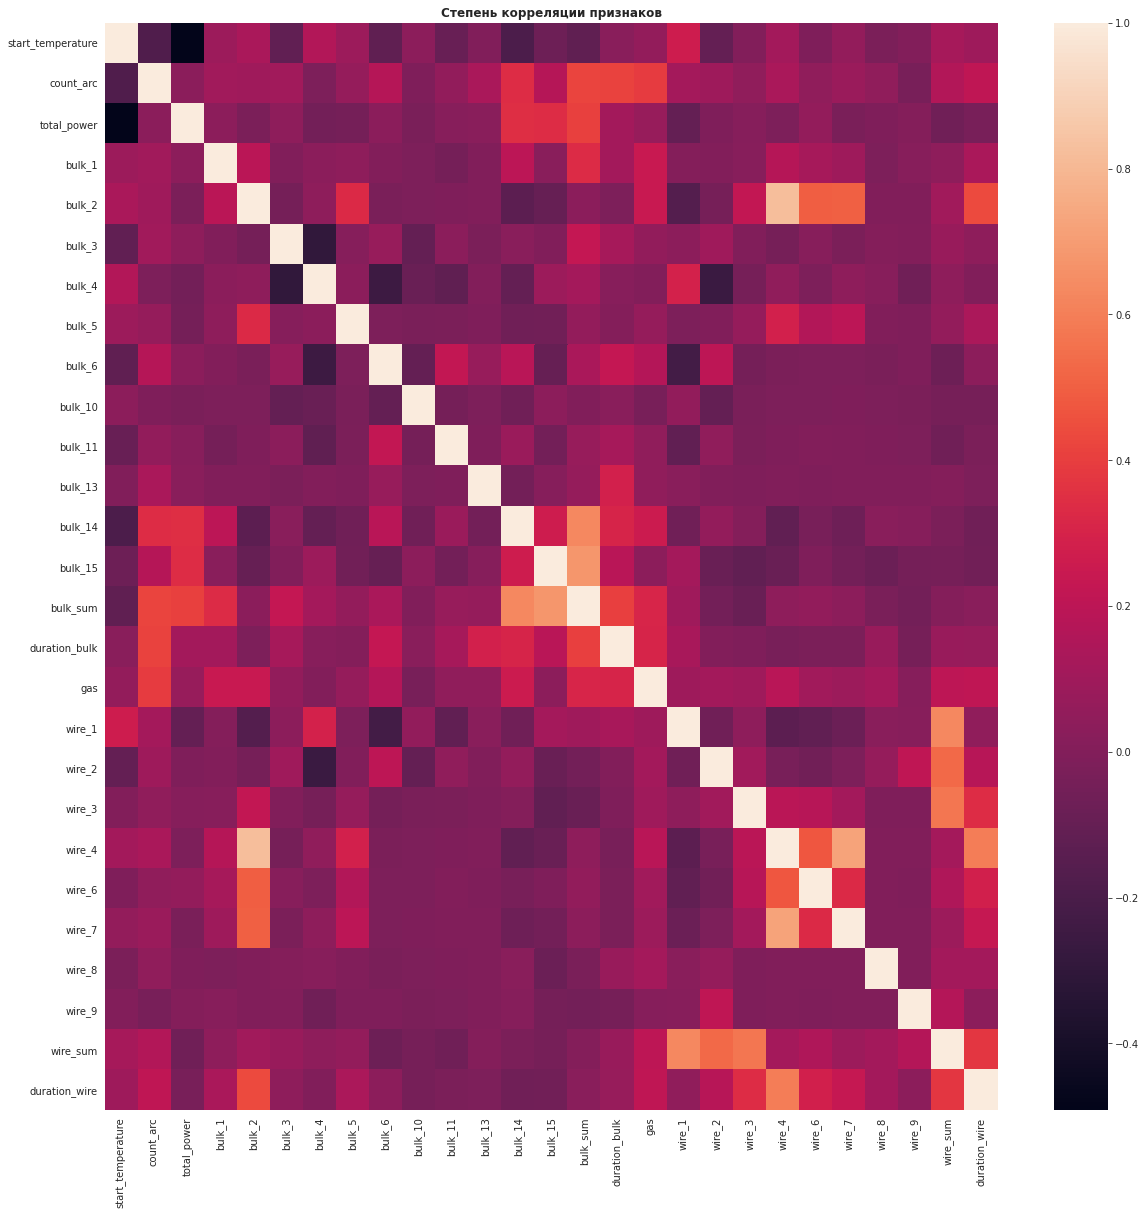

In [69]:
plt.figure(figsize=(20,20))
plt.title('Степень корреляции признаков', fontweight='bold');
sns.heatmap(features_train_lr.corr())
plt.show();

График улучшился, коллинеарность признаков снизилась.

Для проверки моделей на адекватность будем использовать константную модель.

In [70]:
round(mae(target_train, np.ones(features_train.shape[0])*target_train.mean()), 2)

8.05

**Линейная модель**

Линейные модели лучше работают с отмасштабированными данными. Поэтому перед обучение сформируем отмасштабированную тестовую выборку.

In [71]:
scaler = StandardScaler()
features_train_st = scaler.fit_transform(features_train_lr)
features_train_st = pd.DataFrame(features_train_st, columns=features_train_lr.columns)

lr = LinearRegression()
mae_lr = abs(cross_val_score(lr, 
                             features_train_st, 
                             target_train_lr, 
                             cv=5, 
                             scoring='neg_mean_absolute_error')).mean()
round(mae_lr, 2)


6.48

MAE линейной модели на кросс-валидации по обучающей выборке составил 6,48 С, что существенно лучше константного прогноза. Обучим линейную регрессию на полной обучающей выборке и проанализируем признаки.

In [72]:
lr_full = LinearRegression()
lr_full.fit(features_train_st, target_train_lr)

LinearRegression()

Определим функцию для визуализации важности признаков.

In [73]:
def features_importances_plot(features_importances, features_names, model_name):
    feat_importances = (pd.Series(features_importances, index=features_names)
                        .sort_values(ascending=False)
                       )
    plt.figure(figsize=(15,5))
    sns.barplot(x=feat_importances.index, y=feat_importances.values)
    plt.title(f'Наиболее значимые признаки для модели {model_name}', fontweight='bold')
    plt.xticks(rotation=90)

Посмотрим на важность (веса) признаков.

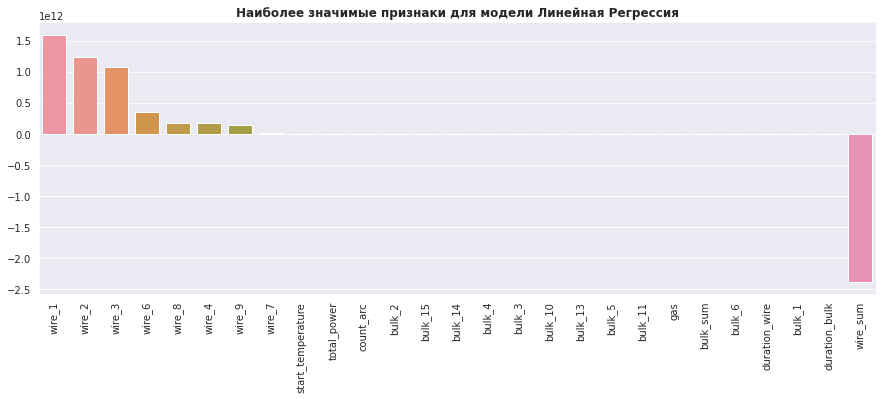

In [74]:
features_importances_plot(features_importances=lr_full.coef_, 
                          features_names=features_train_st.columns, 
                           model_name='Линейная Регрессия')

Наличие мультиколлинеарности отрицательно сказалось на качестве Линейной регрессии. Несмотря на удаления признаков с высокой корреляцией, некоторые коэффициенты имеют большие значения, что может привести к численной неустойчивости и не позволяет корректно проанализировать важность признаков. Посмотрим на регрессию с L1-регуляризацией. Определим функцию для случайного перебора гиперпараметров.

In [75]:
def random_search(model, hyperparams, n_iter=25, features_train=features_train, 
                  target_train=target_train):
    model_srch= RandomizedSearchCV(estimator=model, 
                                  param_distributions=hyperparams,
                                  n_iter=n_iter,
                                  cv=5, 
                                  scoring='neg_mean_absolute_error',
                                  random_state=120922)
    model_srch.fit(features_train, target_train)
    display(f'Лучшие гиперпараметры модели: {model_srch.best_params_}')
    display(f'MAE лучшей модели на кросс-валидации: {round(abs(model_srch.best_score_), 2)}')
    return model_srch

In [76]:
lasso_hyperparams = {'alpha' : np.linspace(0, 1, 100)}
lasso = random_search(Lasso(), 
                      lasso_hyperparams, 
                      n_iter=50, 
                      features_train=features_train_st, 
                      target_train=target_train_lr)

"Лучшие гиперпараметры модели: {'alpha': 0.07070707070707072}"

'MAE лучшей модели на кросс-валидации: 6.19'

In [77]:
lasso_full = Lasso(**lasso.best_params_)
lasso_full.fit(features_train_st, target_train_lr)

Lasso(alpha=0.07070707070707072)

Качество модели улучшилось по сравнению с линейной регрессией без регуляризации. Посмотрим на веса признаков в модели Лассо-регрессии с лучшей метрикой на кросс-валидации.

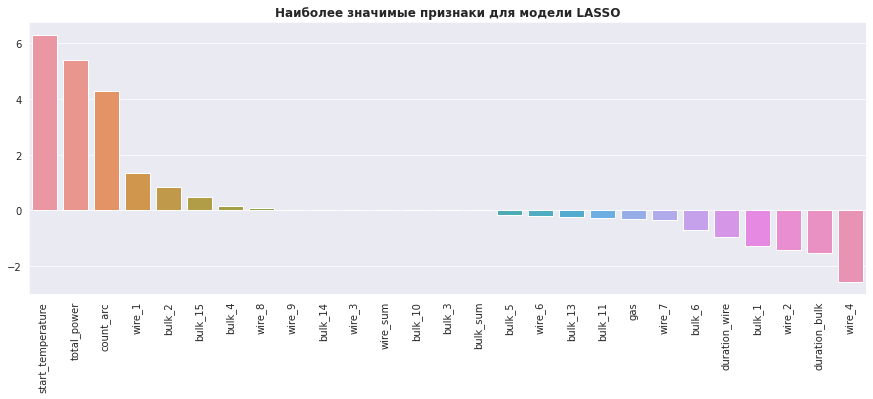

In [78]:
features_importances_plot(features_importances=lasso_full.coef_, 
                                                features_names=features_train_st.columns, 
                                                model_name='LASSO')

Наибольший вес линейной модели с L1-регуляризацией имеет начальная температура. Все параметры характеризующие параметры нагрева электродами значимыми. Обнулились коэффициенты при некоторых сыпучих и проволочных материалах, а также расчетные признаки, характеризующие их суммы.

Таким образом, из линейных моделей на кросс-валидации по обущающей выборке лучшее качество показала модель LASSO (MAE=6.19)

**Случайный лес**

In [79]:
rfr_hyperparams = {'n_estimators': [200],
                   'max_depth': [2, 4, 6],
                   'bootstrap': [False, True]}

rfr = random_search(RandomForestRegressor(random_state=120922, criterion='mae'), 
                    rfr_hyperparams, 
                    n_iter=15, 
                    features_train=features_train, 
                    target_train=target_train)

"Лучшие гиперпараметры модели: {'n_estimators': 200, 'max_depth': 6, 'bootstrap': True}"

'MAE лучшей модели на кросс-валидации: 6.34'

In [80]:
rfr_full = RandomForestRegressor(**rfr.best_params_)
rfr_full.fit(features_train, target_train)

RandomForestRegressor(max_depth=6, n_estimators=200)

Посмотрим на важность (веса) признаков.

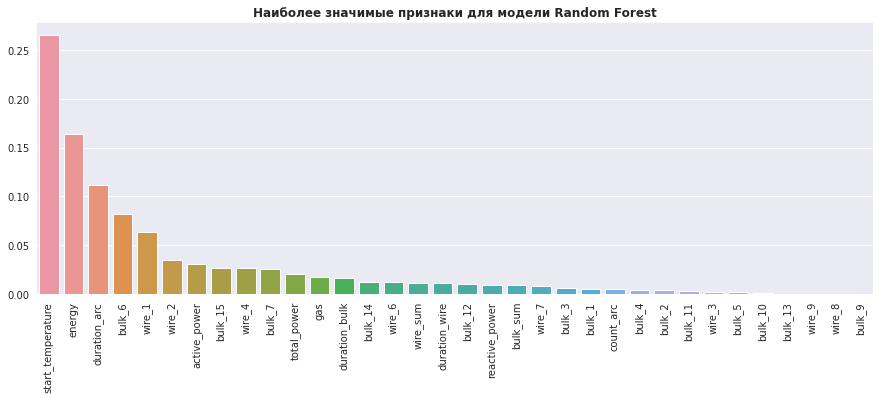

In [81]:
features_importances_plot(features_importances=rfr_full.feature_importances_, 
                          features_names=features_train.columns, 
                          model_name='Random Forest')


Наиболее значимыми признаками по модели Случайного леса, как и у линейной модели Лассо оказались начальная температура и затраченная энергия на обработку. В отличие от модели Лассо для Случайного леса достаточно важными также является общая длительность обработки электродами.

**Градиентный Бустинг**

Для реализации модели градиентного бустинга используем библиотеку LightGBM.

In [82]:
lgb_hyperparams = {'max_depth': range(1, 8, 1),
                   'subsample': np.arange(0.5, 1, 0.1),
                   'feature_fraction': np.arange(0.5, 1, 0.1),
                   'reg_alpha': np.arange(0.5, 1, 0.05),
                   'reg_lambda': np.arange(10, 20, 5)}


lgb = random_search(LGBMRegressor(random_state=120922, metric='mae'), 
                    lgb_hyperparams, 
                    n_iter=50,
                    features_train=features_train, 
                    target_train=target_train)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6



"Лучшие гиперпараметры модели: {'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 0.5, 'max_depth': 6, 'feature_fraction': 0.7999999999999999}"

'MAE лучшей модели на кросс-валидации: 6.08'

In [83]:
lgb_full = LGBMRegressor(n_estimators=1500, learning_rate=0.005, random_state=120922, 
                            metric='mae', **lgb.best_params_)

In [84]:
lgb_full.fit(features_train, target_train)

LGBMRegressor(feature_fraction=0.7999999999999999, learning_rate=0.005,
              max_depth=6, metric='mae', n_estimators=1500, random_state=120922,
              reg_alpha=0.5, reg_lambda=10, subsample=0.6)

Посмотрим на важность (веса) признаков.

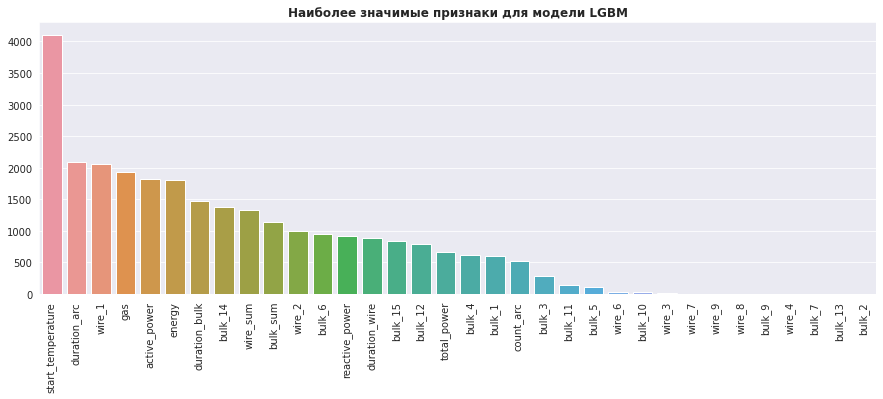

In [85]:
features_importances_plot(features_importances=lgb_full.feature_importances_, 
                                                features_names=features_train.columns, 
                                                model_name='LGBM')

Наиболее значимым признаками по модели Градиентного бустинга оказались начальная температура и затраченная энергия на обработку, также как у Случайного леса и у линейной модели Лассо. Аналогично Случайному лесу достаточно важным признаком является общая длительность обработки электродами. В отличие от модели Лассо и Случайного Леса для Градиентного бустинга достаточно важными также являются признаки, характеризующие суммарное количество материалов и объем газа.

Таким образом, наилучшая модель - это модель Градиентного бустинга c MAE = 6.08 (что меньше значения у констатной модели - 8.05 С) и следующими параметрами:
* feature_fraction=0.7999999999999999, 
* learning_rate=0.005,
* max_depth=6, 
* metric='mae', 
* n_estimators=1500, 
* random_state=120922,
* reg_alpha=0.5, 
* reg_lambda=10, 
* subsample=0.6.   
Данная модель имеет наиболее низкий показатель итоговый MAE. Выберем ее для проверки на тестовой выборке.

## Тестирование модели <a id='#testing'></a> 

In [86]:
lgb_mae_test = round(mae(target_test, lgb_full.predict(features_test)), 2)
lgb_mae_test

6.18

Качество по метрике MAE модели градиентного бустинга на тестовой выборке составила 6,18 С. Соответствующая требованиям заказчика к качеству модели. Данная модель может быть рекомендована для использования при прогнозе конечной температуры стали.

## Отчет по решению <a id='#report'></a> 

### Описание проекта

Для оптимизации потребления электроэнергии на этапе обработки стали металлургического комбината ООО «Так закаляем сталь» было необходимо построить модель, которая  предскажет температуру стали.

### План проекта

Исходный план состоял из следующих пунктов.

1. Предобработка и исследовательский анализ данных. Проверить наличие пропусков, некорректных значений, дубликатов, провести их обработку, привести данные к нужному типу. Изучить признаки, их основные статистики, построить графики при необходимости. Удалить признаки, которые не будут использоваться в обучении моделей (вызывают утечку целевого признака или являются индификаторами). Подготовить итоговую таблицу "признаки-целевой признак", где уникальными ключами являются номера партий.
2. Обучение моделей. Разделить выборку на обучающую и тестовую. Исследовать модели 2 - 3 модели. Выбрать признаковое пространство, модель и ее гиперпараметры, имеющее лучшее качество на кросс-валидации, сравнение с константной моделью.
3. Оценка эффективности моделей на тестовой выборке. При недостижении целевого значения метрики качества вернуться к этапу обучения модели, сформировать дополнительные признаки, продолжить выбор моделей и настройку гиперпараметров. 


### Описание этапов исследования и полученные результаты

**9.2.1 Предобработка и исследовательский анализ данных.**

Предобработка данных является ключевым шагом, от ее качества зависит обучение моделей. Также важным шагом является исследовательский анализ, из которого уже можно понять, какие целевые признаки должны быть выделены, чтобы в дальнейшем обучить модель. В рамках проекта были проанализированы данные, описывающие различные технологические процессы при подготовке стали. Исследование на наличие пропусков, выбросов и ошибочных значений выявило пропуски, обусловленные особенностью технологического производства и выбросы в показателях реактивной мощности (отрицательное значение) и температуре. Явные дубликаты в данных отсутствовали. Поля с датой и временем были преобразованы формат времени.

После анализа были проведены следующие преобразования:
* проведена замена на ноль пропусков, обусловленных  особенностью технологического производства, в таблицах с объемами сыпучих и проволочных материалов;
* дополнены данные об электродах значением общей мощности, общей длительностью обработки электродами, затраченной энергии на обработку, общим количеством этапов обработки, температуре последнего замера в каждой партии (целевой признак);
* удалены из объемов легирующих материалов материалы c единичным значением ввиду нематериальности;
* удалены данные, где замер температуры меньше температуры плавления (меньше 1500 С);
* объединены в одну таблицу по номеру партии;
* удалены признаки, которые не будут использоваться в обучении моделей.

Затем был проведен анализ корреляции (связи величин) признаков между собой и с целевым. Анализ показал высокую корреляцию между характеристиками электродов (количество обработок и длительность, показателями мощности). Некоторые сыпучие и проволочные материалы, предположительно, используются чаще всего вместе, поэтому коррелируют между собой. Признаков сильно коррелирующих с целевым признаком нет.

**9.2.2 Обучение моделей.**

В качестве моделей для обучения были выбраны: Линейная модель, Случайный лес и Градиентный бустинг. Разделение данных на обучающую и тестовую выборки было проведено в соотношении 3:1. Для линейной модели был удален один из пары коррелирующих признаков. Оценка моделей проводилась на кросс-валидации со случайным перебором гиперпараметров (кроме простой линейной модели). Каждая модель была обучена на тестовой выборке. Сравнение моделей проводилось по метрике MAE. Для проверки моделей на адекватность использовалась константная модель с МАЕ = 8.05 С. Зачем анализировалась важность признаков для каждой модели.

**Линейные модели**:  

Линейные модели лучше работают с отмасштабированными данными. Поэтому перед обучение были сформированы отмасштабированная тестовая выборка. Оценка модели - составила 6,48 С, что существенно лучше константного прогноза. Однако несмотря на удаление признаков с высокой корреляцией, некоторые признаки имели большие значения, это могло привести к численной неустойчивости и не позволяло корректно проанализировать важность признаков. Поэтому было принято решение дополнительно посмотреть на регрессию с L1-регуляризацией (модель Лассо). Для модели Лассо проводился случайный перебором гиперпараметра alpha, характеризующего степень регуляризации. Наилучшую оценку (МАЕ - 6.19 C) показала модель со следующим параметром: alpha=0.07070707070707072. Наибольший вес линейной модели с L1-регуляризацией из признаков показала начальная температура. Все параметры характеризующие параметры нагрева электродами значимыми. Обнулились коэффициенты при некоторых сыпучих и проволочных материалах, а также расчетные признаки, характеризующие их суммы.

**Случайный лес**: 

Оценка модели проводилась на кросс-валидации cо случайным перебором гиперпараметров 'max_depth' и 'bootstrap'. Оптимальные значения гиперпараметров: 
* n_estimators=200, 
* max_depth=6,
* bootstrap=True
MAE лучшей модели на кросс-валидации: 6.34C (что меньше значения у констатной модели). Наиболее значимыми признаками по модели Случайного леса, как и у линейной модели Лассо оказались начальная температура и затраченная энергия на обработку. В отличие от модели Лассо для Случайного леса достаточно важной также является общая длительность обработки электродами.

**Градиентный бустинг**: 

Оценка модели проводилась на кросс-валидации со случайным перебором гиперпараметров 'max_depth',  'subsample', 'feature_fraction', 'reg_alpha', 'reg_lambda. Модель имела следующие наилучшие значения параметры: 
* feature_fraction=0.7999999999999999,
* learning_rate=0.005,
* max_depth=6,
* metric='mae',
* n_estimators=1500,
* random_state=120922,
* reg_alpha=0.5,
* reg_lambda=10,
* subsample=0.6. 
Оценка модели составила 6.08С (что меньше значения у константной модели). Наиболее значимым признаками по модели Градиентного бустинга оказались начальная температура и затраченная энергия на обработку, также как у Случайного леса и у линейной модели Лассо. Аналогично Случайному лесу достаточно важным признаком является общая длительность обработки электродами. В отличие от модели Лассо и Случайного Леса для Градиентного бустинга достаточно важными также являются признаки, характеризующие суммарное количество материалов и объем газа.

Модель Градиентного бустинга имела наиболее низкий показатель итоговый MAE, поэтому была выбрана для проверки на тестовой выборке.

**9.2.3 Оценка эффективности моделей на тестовой выборке.**

Качество по метрике MAE модели градиентного бустинга на тестовой выборке составила 6,18 С, соответствующая требованиям заказчика к качеству модели. Данная модель была рекомендована для использования при прогнозе конечной температуры стали.


### Рекомендации

В качестве развития модели предлагается добавить тариф и прогнозировать затраченные расходы на электроэнергию.

### Сравнение плана и факта и основные проблемы при выполнении плана

Все пункты плана были выполнены в полном объеме. За исключением замены на ноль пропусков, обусловленных  особенностью технологического производства, в таблицах с временными показателями, т.к. при дальнеших расчетах эти данные не использовались. Также при использовании простой линейной модели пришлось дополнительно работать с мультиколлинеарностью признаков и исследовать модель с регуляризацией. Дополнительно анализировалась важность признаков для каждой модели. Основные проблемы были связаны с обучением линейной модели: требовалось понимание физического процесса работы (поскольку нужно понимать, какие данные проверять на мультиколлинеарность), необходимо было масштабировать данные для обучения и добавлять дополнительно модель с регуляризацией.